In [19]:
import os, shutil, pathlib
import torchvision
import torch
import pandas as pd
from datetime import datetime

from torch import nn
from torchvision import models
from torch.utils.data import DataLoader, Dataset

import numpy as np
import time

import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from PIL import Image


In [2]:
casez = ["Ext","Loc"]


In [3]:
c = ["Ext","Loc"]

In [4]:
path = pathlib.Path("/home/physics/phubdf/Test_Train_Data")
os.chdir(path)
shutil.rmtree(f"{path}/workspace")
os.mkdir(f"{path}/workspace")

for i in range(0,len(casez)):
    src = os.listdir(f"{path}/{casez[i]}")
    for file in src:
        if file.endswith(".raw"):
            file_name = os.path.join(f"{path}/{casez[i]}", file)
            if os.path.isfile(file_name):
                shutil.copy(file_name, f"{path}/workspace")

In [5]:
shutil.rmtree(f"{path}/labels")
os.mkdir(f"{path}/labels")
for i in range(0,len(casez)):
    csv_input = pd.read_csv(f'{path}/{casez[i]}/labels.csv')
    csv_input.replace(to_replace=0,value=i,inplace = True)
    csv_input.to_csv(f'{path}/labels/labels{c[i]}.csv', index=False)


src = os.listdir(f'{path}/labels')
a = pd.concat([pd.read_csv(f'{path}/labels/{file}') for file in src ], ignore_index=True)
a.to_csv(f'{path}/labels/labels.csv', index=False)


In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = np.loadtxt(f"{img_path}")
        image = image.reshape(1,100,100)
        label = self.img_labels.iloc[idx, 1]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [7]:
batch_size = 32

data = CustomImageDataset(annotations_file=f"{path}/labels/labels.csv",img_dir=f"{path}/workspace")
print(len(data))
#Create Validation set
from torch.utils.data import random_split
training_data, validation_data, test_data = random_split(data,[1600,300,100])

# Create data loaders.

train_dataloader = DataLoader(training_data, batch_size=batch_size)
validation_dataloader = DataLoader(validation_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

2000


In [8]:
train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(train_features)
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels
print(f"Label: {label}")

Feature batch shape: torch.Size([32, 1, 100, 100])
tensor([[[[4.8375e-03, 5.4592e-03, 4.9253e-03,  ..., 4.6378e-03,
           4.8158e-03, 4.6185e-03],
          [5.3517e-03, 5.1188e-03, 5.2807e-03,  ..., 5.1043e-03,
           5.3607e-03, 5.0830e-03],
          [5.1891e-03, 5.3081e-03, 4.6058e-03,  ..., 5.3367e-03,
           5.3026e-03, 4.9194e-03],
          ...,
          [5.2388e-03, 5.4955e-03, 4.5245e-03,  ..., 4.9046e-03,
           4.9402e-03, 5.2020e-03],
          [5.2608e-03, 4.7773e-03, 4.5089e-03,  ..., 4.9777e-03,
           5.4147e-03, 5.0160e-03],
          [4.5041e-03, 4.8294e-03, 5.1805e-03,  ..., 5.3094e-03,
           4.8045e-03, 5.4651e-03]]],


        [[[1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05,
           1.0000e-05, 1.0000e-05],
          [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05,
           1.0000e-05, 1.0000e-05],
          [1.0000e-05, 1.0000e-05, 1.0000e-05,  ..., 1.0000e-05,
           1.0000e-05, 1.0000e-05],
          ...,
      

In [29]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = models.resnet18()
model.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, stride=1, padding=0, bias=False)
model.fc = nn.Linear(in_features=512,out_features=2,bias=True)
print(model)


Using cpu device
ResNet(
  (conv1): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
 

In [30]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [31]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [32]:
epochs = 10
min_valid_loss = np.inf
start = time.time()
tl = np.array([])
vl = np.array([])

for e in range(epochs):
    st = time.time()
    train_loss = 0.0
    model.train()     # Optional when not using Model Specific layer
    for data, labels in train_dataloader:
        data = data.float()
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        optimizer.zero_grad()
        target = model(data)
        loss = loss_fn(target,labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    valid_loss = 0.0
    model.eval()     # Optional when not using Model Specific layer
    for data, labels in validation_dataloader:
        data = data.float()
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        
        target = model(data)
        loss = loss_fn(target,labels)
        valid_loss = loss.item() * data.size(0)
    
    et = time.time()
    rt = et-st

    print(f'Epoch {e+1} \t Runtime: {round(rt,2)}s \t Training Loss: {train_loss / len(train_dataloader)} \t Validation Loss: {valid_loss / len(validation_dataloader)}')
    if min_valid_loss > valid_loss:
        print(f'Validation Loss Decreased({min_valid_loss:.6f}--->{valid_loss:.6f}) \t Saving The Model')
        min_valid_loss = valid_loss
        # Saving State Dict
        torch.save(model.state_dict(), 'saved_model.pth')
    else:
      print(" ")
    
    tl = np.append(tl, train_loss / len(train_dataloader))
    vl = np.append(vl,valid_loss / len(validation_dataloader))

end = time.time()
total = end-start
print(f"Total runtime: {round(total,2)}s")

Epoch 1 	 Runtime: 197.94s 	 Training Loss: 0.3738549408316612 	 Validation Loss: 0.8798331499099732
Validation Loss Decreased(inf--->8.798331) 	 Saving The Model
Epoch 2 	 Runtime: 186.28s 	 Training Loss: 0.18044482424855232 	 Validation Loss: 0.30052528381347654
Validation Loss Decreased(8.798331--->3.005253) 	 Saving The Model
Epoch 3 	 Runtime: 233.83s 	 Training Loss: 0.1289166444540024 	 Validation Loss: 0.15269603133201598
Validation Loss Decreased(3.005253--->1.526960) 	 Saving The Model
Epoch 4 	 Runtime: 195.72s 	 Training Loss: 0.09958625867962838 	 Validation Loss: 0.11716851890087128
Validation Loss Decreased(1.526960--->1.171685) 	 Saving The Model
Epoch 5 	 Runtime: 185.24s 	 Training Loss: 0.07946996256709099 	 Validation Loss: 0.09179451763629913
Validation Loss Decreased(1.171685--->0.917945) 	 Saving The Model
Epoch 6 	 Runtime: 185.0s 	 Training Loss: 0.06462785303592682 	 Validation Loss: 0.07285053580999375
Validation Loss Decreased(0.917945--->0.728505) 	 Saving

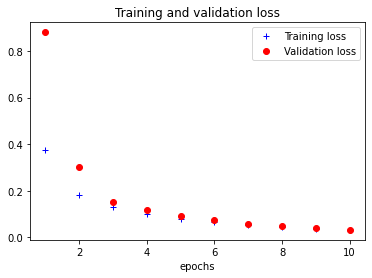

In [33]:
x = np.arange(0,epochs,1)
plt.plot(x+1, tl, "b+", label="Training loss")
np.savetxt(f"tl-E0.1-L0.00001-{datetime.now()}.csv", tl, delimiter=",")
plt.plot(x+1, vl, "ro", label="Validation loss")
np.savetxt(f"vl-E0.1-L0.00001-{datetime.now()}.csv", vl, delimiter=",")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [34]:

predict = []
p = []
device = "cuda" if torch.cuda.is_available() else "cpu"
model.eval()
for i in range(0,20*len(c)):
    x, y = test_data[i][0], test_data[i][1]
    x = x.reshape(1,1,100,100)
    x = torch.from_numpy(x)
    x = x.float()
    with torch.no_grad():
        pred = model(x.cuda()) if torch.cuda.is_available() else model(x)
        predicted, actual = pred[0].argmax(0), y 
        predicted = torch.Tensor.cpu(predicted)
        predict = np.append(predict, predicted)
        p = np.append(p, actual)


In [35]:
cm = confusion_matrix(p, predict)
print(cm)
np.savetxt(f"cm-E0.1-L0.00001-{datetime.now()}.csv", cm, delimiter=",")
score = round(accuracy_score(p, predict)*100,2)
print(f"Model Accuracy: {score}%")

[[23  0]
 [ 0 17]]
Model Accuracy: 100.0%
